# Predicting Bulldozer Selling Price using Time-Series Data

This notebook is practice for using time-series data, as well as regression projects.

The regular six steps are below:

1. Problem Definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Experimentation

## Problem Definition

In a statement,

> Given Time-Series data that contains information about bulldozers, can we predict a proper selling price for it (at an auction) using a machine learning algorithm?

## Data

From Kaggle Competition: https://www.kaggle.com/c/bluebook-for-bulldozers/overview

* *Train.csv* is the training set, which contains data through the end of 2011.
* *Valid.csv* is the validation set, which contains data from January 1, 2012 - April 30, 2012
* *Test.csv* is the test set. It contains data from May 1, 2012 - November 2012.

## Evaluation

> We will pursue this proof of concept if it gets an RMSLE of 0.05 or lower.

## Features

Kaggles provided a data dictionary for the dataset. See the image below.


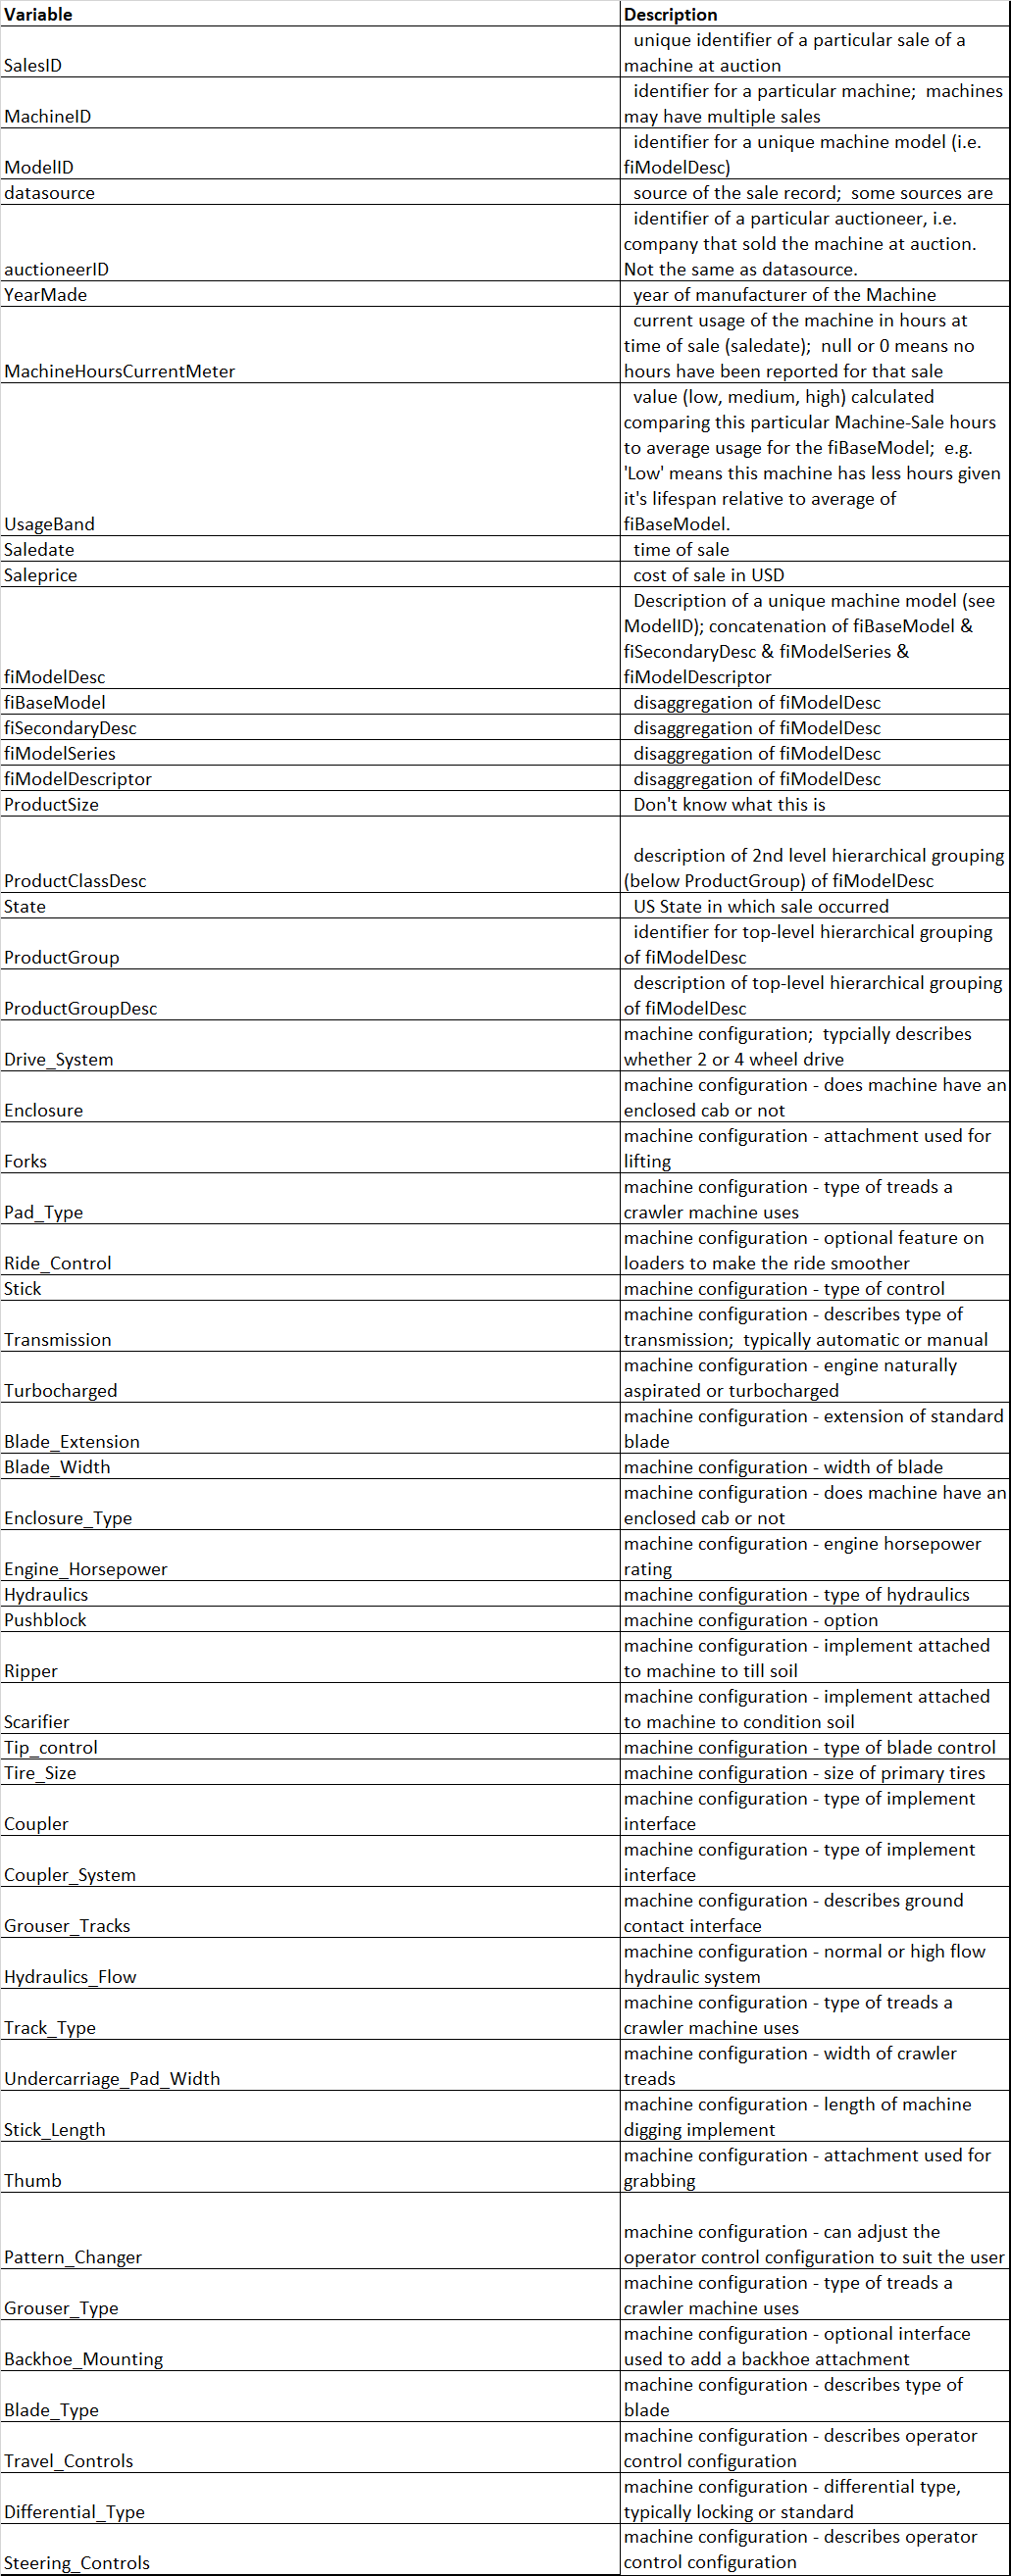

*Note*: For *ProductSize*, The size class grouping for a product group. Subsets within product group.

### Some Quick Notes

* MachineID and saledate can be used to create a new, potentially important feature: Number of times Sold
    * Simply contains the number of times a particular bulldozer have been sold.
* saleprice is the target feature.

In [1]:
# Import the Basics

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load Training & Validation Data

In [2]:
df = pd.read_csv('data/TrainAndValid.csv', low_memory=False)
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

Very little numerical data. A *lot* of null values.

In [4]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

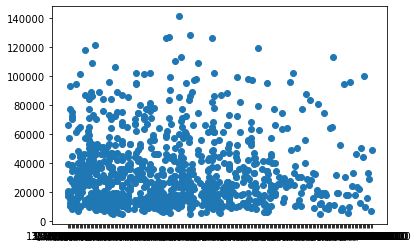

In [5]:
# Let's plot saleprices over time

fig, ax = plt.subplots()

ax = plt.scatter(df['saledate'][:1000], df['SalePrice'][:1000]); # Looks funky

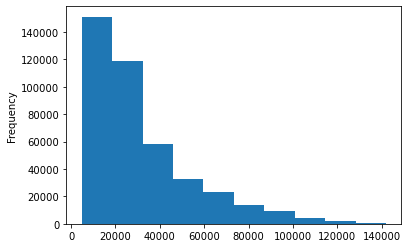

In [6]:
df.SalePrice.plot.hist();

In [7]:
df.saledate.dtype

dtype('O')

### Parsing Dates

When we work with time series data, we want to enrich the time & date component as much as possible.

We can do that by telling Pandas which of our columns have dates dates in it using the `parse_dates` parameter. Turns the column into a *datetime* object.

In [8]:
# Import data again, but this time parse dates

df = pd.read_csv('data/TrainAndValid.csv', low_memory = False, parse_dates=['saledate'])
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df.saledate.dtype

dtype('<M8[ns]')

In [10]:
df.saledate[:100]

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
        ...    
95   2005-12-15
96   2004-01-29
97   2008-09-18
98   2005-11-03
99   2006-06-01
Name: saledate, Length: 100, dtype: datetime64[ns]

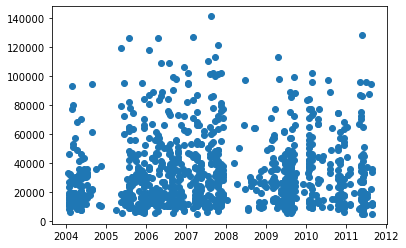

In [11]:
fig, ax = plt.subplots()

ax = plt.scatter(df['saledate'][:1000], df['SalePrice'][:1000]); # Looks better!

In [12]:
# A trick to see every feature in the dataframe:

df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [13]:
df.saledate.head(20)

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

### Sort DataFrame by saledate

When working with time series data, it's a good idea to sort it by date.

In [14]:
df.sort_values(by=['saledate'], inplace=True, ascending=True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make a copy of the original DataFrame

Good to idea because when we manipulate the copy, we'll stil have access to the original dataframe.

In [15]:
df_tmp = df.copy()

In [16]:
df.saledate.head(20) # The exact same

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Add datetime parameters for `saledate` column

Adds more potentially enriching data for our ML model to use.

In [17]:
df_tmp['saleYear'] = df_tmp.saledate.dt.year
df_tmp['saleMonth'] = df_tmp.saledate.dt.month
df_tmp['saleDay'] = df_tmp.saledate.dt.day

df_tmp['saleDayOfWeek'] = df_tmp.saledate.dt.dayofweek
df_tmp['saleDayOfYear'] = df_tmp.saledate.dt.dayofyear

In [18]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [19]:
# Since we added columns to replace saledate, we can remove it. Plus there's also a few other columns :)
# If we ever wanted it back, we can use our original dataframe!

df_tmp.drop('saledate', axis=1, inplace=True)

In [20]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [21]:
df_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

In [22]:
df_tmp.MachineID.value_counts()

2283592    48
2285830    44
1896854    40
1746392    34
2268800    31
           ..
618301      1
1212137     1
1169901     1
1136154     1
1869284     1
Name: MachineID, Length: 348808, dtype: int64

In [23]:
test_1 = df_tmp[df_tmp['MachineID'] == 2283592] 
test_2 = df_tmp[df_tmp['MachineID'] == 2285830]
test = pd.concat([test_1, test_2])
test.MachineID.value_counts()

2283592    48
2285830    44
Name: MachineID, dtype: int64

In [24]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN


In [25]:
# Create a numOfTimesSold column

def numOfTimesSoldFunc(df):
    """
    Counts up the number of occurances of a particular machine being sold. Each row is assigned a number of times the machine as already been sold before.
    """
    empty_dict = {}
    numOfTimesSold = []
    index = -1
    counter = 0
    for key in list(df.keys()):
        if key == 'MachineID':
            index = counter
            break
        else:
            counter += 1
    for i in range(len(df)):
        row = df.iloc[i]
        #print(row)
        if row[index] in list(empty_dict.keys()):
            #print(row[2])
            empty_dict[row[index]] += 1
        else:
            empty_dict[row[index]] = 0
        numOfTimesSold.append(empty_dict[row[index]])
    #print(numOfTimesSold)
    df['TimesSold'] = numOfTimesSold
    return df

In [26]:
# Testing the above function -> IT WORKS!!!

test_results = numOfTimesSoldFunc(test)
test_results

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear,TimesSold
385681,4319298,12000.0,2283592,4579,172,1.0,2002,3802.0,Medium,210LE,...,NaN,NaN,Standard,Conventional,2011,5,24,1,144,0
385691,4319348,16000.0,2283592,4579,172,1.0,2006,1764.0,Low,210LE,...,NaN,NaN,Standard,Conventional,2011,6,7,1,158,1
385690,4319347,24000.0,2283592,4579,172,1.0,2006,831.0,Low,210LE,...,NaN,NaN,Standard,Conventional,2011,6,10,4,161,2
385678,4319295,19500.0,2283592,4579,172,1.0,2005,0.0,NaN,210LE,...,NaN,NaN,Standard,Conventional,2011,6,16,3,167,3
385696,4319353,13000.0,2283592,4579,172,1.0,2004,3405.0,Medium,210LE,...,NaN,NaN,Standard,Conventional,2011,6,21,1,172,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404365,4320919,26000.0,2285830,4605,172,1.0,2006,0.0,NaN,310G,...,NaN,NaN,NaN,NaN,2012,3,29,3,89,39
404366,4320924,30000.0,2285830,4605,172,1.0,2005,5985.0,High,310G,...,NaN,NaN,NaN,NaN,2012,4,10,1,101,40
404367,4320925,20000.0,2285830,4605,172,1.0,2005,1598.0,Low,310G,...,NaN,NaN,NaN,NaN,2012,4,12,3,103,41
404368,4320926,25000.0,2285830,4605,172,1.0,2005,1835.0,Low,310G,...,NaN,NaN,NaN,NaN,2012,4,17,1,108,42


In [27]:
# Let's try it on our overall dataframe -> Took years to do, so I saved the edited version.

#df_tmp = numOfTimesSoldFunc(df_tmp)
#df_tmp.head()

In [28]:
#df_tmp.to_csv(path_or_buf='df_tmp_edited.csv', index=False)

In [29]:
df_tmp = pd.read_csv('df_tmp_edited.csv', low_memory=False)
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear,TimesSold
0,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17,0
1,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,Standard,Conventional,1989,1,31,1,31,0
2,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31,0
3,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,...,NaN,NaN,Standard,Conventional,1989,1,31,1,31,0
4,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,...,PAT,Lever,NaN,NaN,1989,1,31,1,31,0


## Let's try some Basic Modelling

Let's try some model-driven EDA.

### Preprocessing

First, we have to do some serious preprocessing to make everything usuable with our algorithms.

In [30]:
df_tmp.dtypes

SalesID                       int64
SalePrice                   float64
MachineID                     int64
ModelID                       int64
datasource                    int64
auctioneerID                float64
YearMade                      int64
MachineHoursCurrentMeter    float64
UsageBand                    object
fiModelDesc                  object
fiBaseModel                  object
fiSecondaryDesc              object
fiModelSeries                object
fiModelDescriptor            object
ProductSize                  object
fiProductClassDesc           object
state                        object
ProductGroup                 object
ProductGroupDesc             object
Drive_System                 object
Enclosure                    object
Forks                        object
Pad_Type                     object
Ride_Control                 object
Stick                        object
Transmission                 object
Turbocharged                 object
Blade_Extension             

In [31]:
#Let's decide our features

categorical_features = df_tmp.dtypes==object
categorical_features = categorical_features[categorical_features == True]
categorical_features = list(categorical_features.keys())

numerical_features = df_tmp.dtypes!=object
numerical_features = numerical_features[numerical_features == True]
numerical_features = list(numerical_features.keys())



categorical_features, numerical_features

(['UsageBand',
  'fiModelDesc',
  'fiBaseModel',
  'fiSecondaryDesc',
  'fiModelSeries',
  'fiModelDescriptor',
  'ProductSize',
  'fiProductClassDesc',
  'state',
  'ProductGroup',
  'ProductGroupDesc',
  'Drive_System',
  'Enclosure',
  'Forks',
  'Pad_Type',
  'Ride_Control',
  'Stick',
  'Transmission',
  'Turbocharged',
  'Blade_Extension',
  'Blade_Width',
  'Enclosure_Type',
  'Engine_Horsepower',
  'Hydraulics',
  'Pushblock',
  'Ripper',
  'Scarifier',
  'Tip_Control',
  'Tire_Size',
  'Coupler',
  'Coupler_System',
  'Grouser_Tracks',
  'Hydraulics_Flow',
  'Track_Type',
  'Undercarriage_Pad_Width',
  'Stick_Length',
  'Thumb',
  'Pattern_Changer',
  'Grouser_Type',
  'Backhoe_Mounting',
  'Blade_Type',
  'Travel_Controls',
  'Differential_Type',
  'Steering_Controls'],
 ['SalesID',
  'SalePrice',
  'MachineID',
  'ModelID',
  'datasource',
  'auctioneerID',
  'YearMade',
  'MachineHoursCurrentMeter',
  'saleYear',
  'saleMonth',
  'saleDay',
  'saleDayOfWeek',
  'saleDayOfYe

In [32]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

In [33]:
df_tmp['ModelID'].value_counts()

4605     5348
3538     4976
3170     4364
4604     4296
3362     4186
         ... 
3198        1
16176       1
3475        1
26334       1
13976       1
Name: ModelID, Length: 5281, dtype: int64

In [34]:
df_tmp['Coupler'].value_counts()

None or Unspecified    190449
Manual                  23918
Hydraulic                6312
Name: Coupler, dtype: int64

I'm going to go through each nan containing column and figure out what to do with each of them.

* All machine configuration null values will be turned into 'None' because they simply don't have those values.
    * It seems that 'None or Unspecified' is the term used in the machine configuration categories.
* ProductSize can be used for imputation.
    * Though it'll be less accurate, we'll use MachineHoursCurrentMeter & UsageBand too.
* Since fiModelDesc is simply the concatentation of all the other descriptors, I'll get rid of it.
* fiSecondaryDesc, fiModelSeries, and fiModelDescriptor will use the 'None or Unspecified' term, because inaccuracies may result from imputing them randomly.
* For auctioneerID, we'll use a new value, 101, to denote the unknown ids.


I'm gonna use the autoimpute package. See: https://pypi.org/project/autoimpute/ for more information. https://autoimpute.readthedocs.io/en/latest/user_guide/getting_started.html for the documentation.

*Note*: I'll only impute the current columns that possess missing data, for time reasons. I *should* be creating an imputation strategy for every single one, but let's not focus on that :)

**UPDATE**: I tried to use autoimpute, but there's many errors being thrown up, and I wanna get on with the project. I'm switching to the SimpleImputer Method.

In [35]:

from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from autoimpute.imputations import MiceImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# First, drop the 'fiModelDesc' column, but we'll do that in the ColumnTransformer using a weird trick.

unwanted_features = ['fiModelDesc', 'SalesID', 'MachineID', 'datasource', 'saledate']
wanted_features = categorical_features.copy()
wanted_features.remove('fiModelDesc')

# Second, we must impute the None columns

none_features = categorical_features[11:]
none_features.append('fiSecondaryDesc')
none_features.append('fiModelSeries')
none_features.append('fiModelDescriptor')
none_features.append('ProductSize')
none_features.append('UsageBand')


none_imputer = SimpleImputer(strategy='constant', fill_value='None or Unspecified')

# Next, the number imputation.

id_features = ['auctioneerID']

id_imputer = SimpleImputer(strategy='constant', fill_value=101)

hours_features = ['MachineHoursCurrentMeter']

hours_imputer = SimpleImputer(strategy='median')

# Then, the MiceImputer for ProductSize, MachineHoursCurrentMeter, and UsageBand

# # Documentation on AutoImpute is a bit iffy, so I'm just going to use the MiceImputer() on the three columns that we want to use.

#iterative_features = ['ProductSize', 'MachineHoursCurrentMeter', 'UsageBand']

#iterative_imputer = MiceImputer(return_list=True)

# Next, a OneHotEncoder for the categorical features

one_encoder = OneHotEncoder(sparse=True, handle_unknown='ignore')

# Now, an Overall Column Transformer! (Gotta use this in the pipeline since everything sucks OuO.)

transformer = ColumnTransformer([
    ('drop_features', 'drop', unwanted_features),
    ('none_imputer', none_imputer, none_features),
    ('id_imputer', id_imputer, id_features),
    ('hours_imputer', hours_imputer, hours_features)
    
], remainder='passthrough')


In [36]:
# I'm going to create a custom transformer that does all the preprocessing we did earlier (not to be used in this pipeline! Since we already did it!)

from sklearn.base import BaseEstimator, TransformerMixin

# # It assumes that the csv was imported with saledate as time-series data.
class CustomBulldozing(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        #print(X.keys())
        return self
    
    def transform(self, X, y=None):
        # Get Dates!
        
        #print(X.keys())
        
        X_ = X.copy()
        
        X_['saleYear'] = X_['saledate'].dt.year
        X_['saleMonth'] = X_['saledate'].dt.month
        X['saleDay'] = X_['saledate'].dt.day

        X_['saleDayOfWeek'] = X_['saledate'].dt.dayofweek
        X_['saleDayOfYear'] = X_['saledate'].dt.dayofyear
        
        # Get rid of saledate now that it's redundant.
        
        #X_ = X_.drop('saledate', axis=1)
        
        
        # Add another column
        
        X_ = numOfTimesSoldFunc(X_)
        
        return X_

In [37]:
# Now, let's acquire a StandardScaler

scaler = StandardScaler(with_mean=False)

# Finally, the pipeline (minus our model)

pipeline = Pipeline([
    ('transformer', transformer),
    ('encoder', one_encoder),
    ('scaler', scaler)
])

In [38]:

'''
X_comp = df_tmp.drop('SalePrice', axis=1)[:1000]
X_comp.set_index('SalesID', inplace=True)
X_comp.reset_index(drop=True, inplace=True)
X_comp.head()
'''

"\nX_comp = df_tmp.drop('SalePrice', axis=1)[:1000]\nX_comp.set_index('SalesID', inplace=True)\nX_comp.reset_index(drop=True, inplace=True)\nX_comp.head()\n"

In [39]:
# Let's test it out (on a small subsection of our data)
# # Important to NOTE: if a column is entirely empty, than MICE will throw an error.
'''
X_comp = df_tmp.drop('SalePrice', axis=1)[:1000]
X_exp = X_comp.copy()
X_exp = pipeline.fit_transform(X_exp)
X_comp, X_exp
'''

"\nX_comp = df_tmp.drop('SalePrice', axis=1)[:1000]\nX_exp = X_comp.copy()\nX_exp = pipeline.fit_transform(X_exp)\nX_comp, X_exp\n"

Everything looks to be in order. Let's continue!

In [40]:
# Create the pipeline with the model.

pipeline = Pipeline([
    ('transformer', transformer),
    ('encoder', one_encoder),
    ('scaler', scaler),
    ('model', RandomForestRegressor(n_jobs=-1, random_state=42, max_samples=10000))
])

In [41]:
# Now, split the data.

from sklearn.model_selection import train_test_split

X = df_tmp.drop('SalePrice', axis=1)

y = df_tmp['SalePrice']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

In [42]:
X_train.head(), X_valid.head()

(        SalesID  MachineID  ModelID  datasource  auctioneerID  YearMade  \
 379287  1149905      62713     1629         121           3.0      2006   
 31127   1821560    1133687     5640         132           2.0      1987   
 23420   1857949    1259273    10731         132           2.0      1985   
 336936  2303751     779848     1269         136           1.0      2004   
 7251    1258888    1287059     6788         132          18.0      1974   
 
         MachineHoursCurrentMeter UsageBand fiModelDesc fiBaseModel  ...  \
 379287                    7430.0      High   D6RIIILGP          D6  ...   
 31127                        NaN       NaN        655A         655  ...   
 23420                        NaN       NaN         530         530  ...   
 336936                       0.0       NaN       330CL         330  ...   
 7251                         NaN       NaN         580         580  ...   
 
        Blade_Type     Travel_Controls Differential_Type Steering_Controls  \
 37928

In [43]:
%%time

# Let's train!


#model = pipeline.fit(X_train, y_train) # Thirteen minutes to train :) Wow.

CPU times: total: 0 ns
Wall time: 0 ns


In [44]:
# Lemme score just because OuO -> training

#model.score(X_train, y_train)

In [45]:
# Validation -> Raises error because the OneHotEncoder handles unknown values with 'error'. Future pipeline will use 'ignore'.

# model.score(X_valid, y_valid)

### Building an Evaluation Function



In [46]:
# Create Evaluation Function

from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error, r2_score

def rmsle(y_test, y_preds):
    """
    Calculates the root mean squared error (RMSLE) between predictions and true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

def show_scores(model, transformer):
    
    train_preds = model.predict(transformer.transform(X_train))
    val_preds = model.predict(transformer.transform(X_valid))
    
    scores = {'Training MAE' : mean_absolute_error(y_train, train_preds),
             'Training RMSLE' : rmsle(y_train, train_preds),
              'Training R^2' : r2_score(y_train, train_preds),
             'Valid MAE' : mean_absolute_error(y_valid, val_preds),
             'Valid RMSLE' : rmsle(y_valid, val_preds),
              'Valid R^2' : r2_score(y_valid, val_preds)
             }
    return scores

In [47]:
# Let's split it up properly (according to the blue book.)

df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

In [48]:
X_train = df_train.drop('SalePrice', axis=1)

y_train = df_train['SalePrice']

X_valid = df_val.drop('SalePrice', axis=1)

y_valid = df_val['SalePrice']

In [49]:
# Training it properly now.

model = Pipeline([
    ('transformer', transformer),
    ('encoder', one_encoder),
    ('scaler', scaler),
    ('model', RandomForestRegressor(n_jobs=-1, random_state=42, max_samples=10000))
])

#model.fit(X_train, y_train)

In [50]:
#show_scores(model)

In [51]:
from joblib import dump

#dump(model, 'modelpipeline.joblib')

In [52]:
from joblib import load

model = load('modelpipeline.joblib')

### Hyperparameter Tuning with RandomizedSearchCV

In [53]:
from sklearn.model_selection import RandomizedSearchCV

rf_grid = {'n_estimators' : np.arange(10, 100, 10),
          'max_depth' : [None, 3, 5, 10],
          'min_samples_split' : np.arange(2, 20, 2),
          'min_samples_leaf' : np.arange(1, 20, 2),
          'max_features' : [0.5, 1, 'sqrt', 'auto'],
          'max_samples' : [10000]}

# Make a transformation pipeline.

pipe = Pipeline([
    ('transformer', transformer),
    ('encoder', one_encoder),
    ('scaler', scaler),
])

# We'll transform the data first, then use a basic RandomForestRegressor to test.

random_X_train = model.fit_transform(X_train)

# Instantiate

rs_model = RandomizedSearchCV(RandomForestRegressor(),
    n_jobs=-1,
    random_state=42,
    param_distributions=rf_grid,
    n_iter=10,
    cv=5,
    verbose=True
)

# Fit it

#rs_model.fit(random_X_train, y_train)

ValueError: This RandomForestRegressor estimator requires y to be passed, but the target y is None.

In [54]:
# Best hyperparameters

#rs_model.best_params_

In [55]:
#model

In [56]:
# Evaluate the RandomizedSearch model

#show_scores(rs_model, model)

### Make Predictions on the Test Data

In [57]:
# Importing train.csv

df_train = pd.read_csv('data/Train.csv', low_memory=False, parse_dates=['saledate'])

In [58]:
df_train.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
# Split X & y

X_train = df_train.drop('SalePrice', axis=1)

y_train = df_train['SalePrice']

In [60]:
X_train.head(), y_train.head()

(   SalesID  MachineID  ModelID  datasource  auctioneerID  YearMade  \
 0  1139246     999089     3157         121           3.0      2004   
 1  1139248     117657       77         121           3.0      1996   
 2  1139249     434808     7009         121           3.0      2001   
 3  1139251    1026470      332         121           3.0      2001   
 4  1139253    1057373    17311         121           3.0      2007   
 
    MachineHoursCurrentMeter UsageBand   saledate fiModelDesc  ...  \
 0                      68.0       Low 2006-11-16        521D  ...   
 1                    4640.0       Low 2004-03-26      950FII  ...   
 2                    2838.0      High 2004-02-26         226  ...   
 3                    3486.0      High 2011-05-19    PC120-6E  ...   
 4                     722.0    Medium 2009-07-23        S175  ...   
 
   Undercarriage_Pad_Width Stick_Length Thumb Pattern_Changer Grouser_Type  \
 0                     NaN          NaN   NaN             NaN          N

In [61]:
# Importing test.csv

df_test = pd.read_csv('data/Test.csv', low_memory=False, parse_dates=['saledate'])

In [62]:
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [63]:
custom = CustomBulldozing()
test_data = custom.fit_transform(df_test)
test_data.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDayOfWeek,saleDayOfYear,TimesSold
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,2012,5,3,124,0
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,Standard,Conventional,2012,5,3,131,0
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,NaN,NaN,NaN,NaN,NaN,2012,5,3,131,0
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,NaN,NaN,NaN,NaN,NaN,2012,5,3,131,0
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,None or Unspecified,PAT,None or Unspecified,NaN,NaN,2012,5,3,131,0


#### Make Preprocessed Pipeline

Recall: `CustomBulldozing()` is the custom transformer that I constructed to make things easy on me.

In [64]:
custom = CustomBulldozing()

final_model = Pipeline([
    ('preprocessing', custom),
    ('transformer', transformer),
    ('encoder', one_encoder),
    ('scaler', scaler),
    ('model', RandomForestRegressor(n_estimators=80,
                                     min_samples_split=14,
                                     min_samples_leaf=11,
                                     max_features=0.5,
                                     max_depth=None,
                                     n_jobs=-1, random_state=42, max_samples=10000))
])

In [65]:
# Let's grab the SalesID (for indexing)
# # Data doesn't have target column, so we don't need to worry about that.

index = df_test['SalesID']

In [66]:
df_test.saledate

0       2012-05-03
1       2012-05-10
2       2012-05-10
3       2012-05-10
4       2012-05-10
           ...    
12452   2012-10-24
12453   2012-10-24
12454   2012-10-24
12455   2012-10-24
12456   2012-09-19
Name: saledate, Length: 12457, dtype: datetime64[ns]

In [67]:
# Let's train our model.

#final_model.fit(X_train, y_train)

In [68]:
from joblib import dump, load

#dump(final_model, 'final_model.joblib')

final_model = load('final_model.joblib')

In [71]:
# Let's make some predictions!



y_preds = final_model.predict(df_test)

In [72]:
index

0        1227829
1        1227844
2        1227847
3        1227848
4        1227863
          ...   
12452    6643171
12453    6643173
12454    6643184
12455    6643186
12456    6643196
Name: SalesID, Length: 12457, dtype: int64

In [73]:
final_predictions = pd.DataFrame()
final_predictions["SalesID"] = df_test["SalesID"]
final_predictions["SalesPrice"] = y_preds
final_predictions

,SalesID,SalesPrice
0,1227829,23951.759472
1,1227844,31350.819010
2,1227847,58654.593227
3,1227848,83875.850949
4,1227863,29141.822186
...,...,...
12452,6643171,35681.276589
12453,6643173,21421.239965
12454,6643184,21395.864573
12455,6643186,23551.495583


In [74]:
# Let's export this now!

final_predictions.to_csv('final_predictions.csv', index=False)

### Feature Importance

We want to figure out which features were most important for the prediction of the sale price of a bulldozer.

In [77]:
stuff = final_model.named_steps['encoder'].get_feature_names_out()
len(stuff)

27547

In [80]:
final_model.named_steps['encoder']

AttributeError: 'OneHotEncoder' object has no attribute 'feature_names_in_'

In [ ]:
def get_feature_names():  
        
        column_transformer = preproc      

        new_feature_names = []

        for i, transformer_item in enumerate(column_transformer.transformers_): 
            
            transformer_name, transformer, orig_feature_names = transformer_item
            orig_feature_names = list(orig_feature_names)
                
            if isinstance(transformer, Pipeline):
                # if pipeline, get the last transformer in the Pipeline
                transformer = transformer.steps[-1][1]

            if hasattr(transformer, 'get_feature_names'):

                if 'input_features' in transformer.get_feature_names.__code__.co_varnames:

                    names = list(transformer.get_feature_names(orig_feature_names))

                else:

                    names = list(transformer.get_feature_names())


            new_feature_names.extend(names)
        
        return new_feature_names